# Example - One Step

In this notebook, we use the numerical probability generation functions and the numerical mutual information function to compute the mutual information.

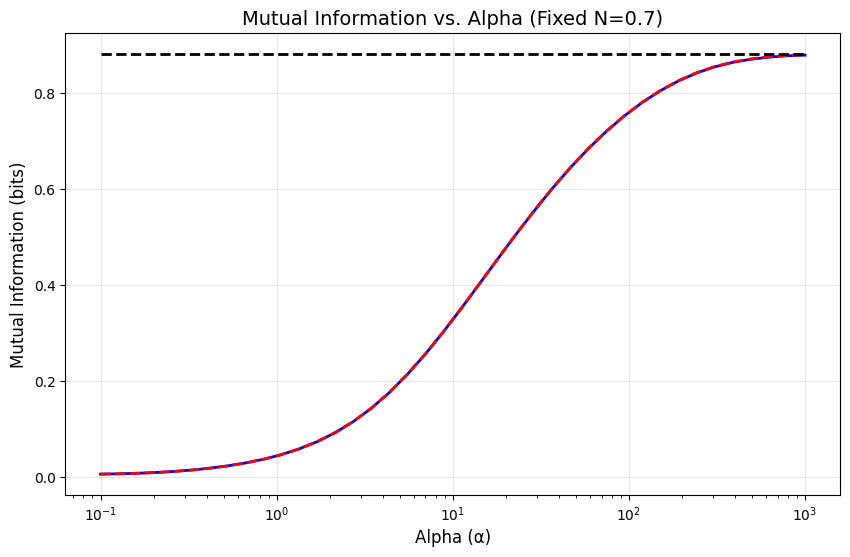

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from binary_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep)

# Define rates
N = 0.7  # Fixed occupation number
A_values = np.logspace(-1, 3, 40)  # Range of alpha values to test

# Time parameters
t_max = 30.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
initial_p = np.array([1.0, 0.0])  # Start in OFF state
num_states = len(initial_p)

# Storage for results
mutual_infos_num = []
mutual_infos_analytic = []

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    k_on, k_off, alpha = rates_from_params(N, A)

    mi, joint_ent, t_ent, x_ent = mutual_information_calc(k_on, k_off, alpha, t_eval, dt)
    mutual_infos_analytic.append(mi)
    
    # Obtain PDFs
    steady_state = steady_state_sim(two_state_system_dt, initial_p, t_max, dt, k_on, k_off)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = survival_probabilities_given_initial_state(two_state_system_detection_dt, num_states, t_max, dt,
                                                  k_off, k_on, alpha)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_prob = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    joint_entropy, time_entropy = numerical_mutual_info_onestep(t_eval, dt, initial_state, prob_time_since_last_event)
    mi_numeric = time_entropy + x_ent - joint_entropy
    mutual_infos_num.append(mi_numeric)

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(A_values, mutual_infos_num, 'b-', linewidth=2, label="Maximum Mutual Information (numeric)")
plt.plot(A_values, mutual_infos_analytic, 'r--', linewidth=2, label="Maximum Mutual Information (analytic)")

plt.plot(A_values, np.ones_like(A_values)*x_ent, 'k--', linewidth=2 , label = "Entropy of X")

plt.xlabel('Alpha (α)', fontsize=12)
plt.ylabel('Mutual Information (bits)', fontsize=12)
plt.title(f'Mutual Information vs. Alpha (Fixed N={N})', fontsize=14)
plt.xscale('log') 
plt.grid(True, alpha=0.3)
plt.show()


We can also perform the same calculation for the mutual information with the initial condition, which in this case returns the same result

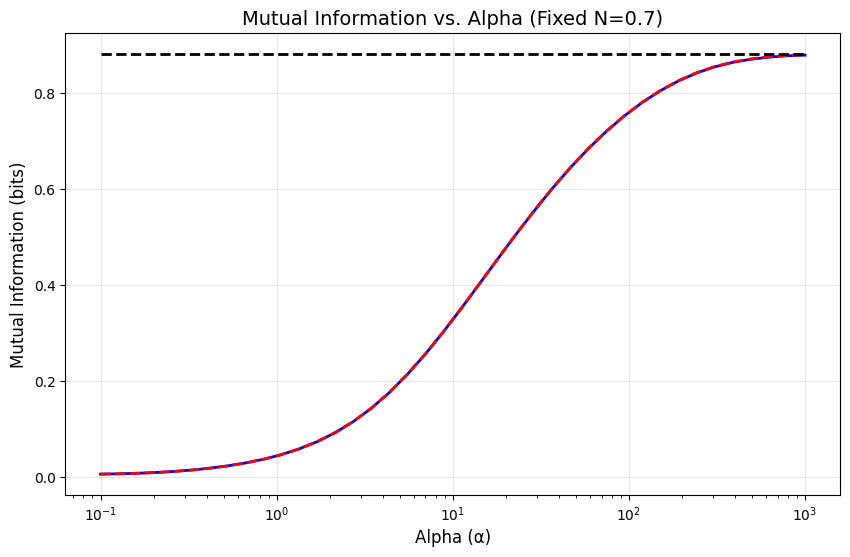

In [2]:
from binary_markov_funcs import numerical_mutual_info_onestep_with_init
mutual_infos_num_init = []

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    k_on, k_off, alpha = rates_from_params(N, A)

    # Obtain PDFs
    steady_state = steady_state_sim(two_state_system_dt, initial_p, t_max, dt, k_on, k_off)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = survival_probabilities_given_initial_state(two_state_system_detection_dt, num_states, t_max, dt,
                                                  k_off, k_on, alpha)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_prob = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    joint_entropy, time_entropy = numerical_mutual_info_onestep_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    mi_numeric = time_entropy + x_ent - joint_entropy
    mutual_infos_num_init.append(mi_numeric)

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(A_values, mutual_infos_num_init, 'b-', linewidth=2, label="Maximum Mutual Information (numeric, with init)")
plt.plot(A_values, mutual_infos_analytic, 'r--', linewidth=2, label="Maximum Mutual Information (analytic)")

plt.plot(A_values, np.ones_like(A_values)*x_ent, 'k--', linewidth=2 , label = "Entropy of X")

plt.xlabel('Alpha (α)', fontsize=12)
plt.ylabel('Mutual Information (bits)', fontsize=12)
plt.title(f'Mutual Information (with initial condition) vs. Alpha (Fixed N={N})', fontsize=14)
plt.xscale('log') 
plt.grid(True, alpha=0.3)
plt.show()


Which yields the same results as expected.

# Multiple Detection Events

We combine all of this in a program that works for one and two detection events.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from binary_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep,
                                numerical_mutual_info_onestep_with_init,
                                numerical_mutual_info_twostep,
                                numerical_mutual_info_twostep_with_init)

# Define rates
N = 0.7  # Fixed occupation number
A_values = np.logspace(-1, 2, 10)  # Range of alpha values to test

# Time parameters
t_max = 30.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
initial_p = np.array([1.0, 0.0])  # Start in OFF state
num_states = len(initial_p)

# Storage for results
mutual_infos_num = []
mutual_infos_num_with_init = []
mutual_infos_num_2step = []
mutual_infos_num_2step_with_init = []

mutual_infos_analytic = []

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    k_on, k_off, alpha = rates_from_params(N, A)

    mi, joint_ent, t_ent, x_ent = mutual_information_calc(k_on, k_off, alpha, t_eval, dt)
    mutual_infos_analytic.append(mi)
    
    # Obtain PDFs
    steady_state = steady_state_sim(two_state_system_dt, initial_p, t_max, dt, k_on, k_off)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = survival_probabilities_given_initial_state(two_state_system_detection_dt, num_states, t_max, dt,
                                                  k_off, k_on, alpha)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_probs = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)

    joint_entropy, time_entropy = numerical_mutual_info_onestep(t_eval, dt, initial_state, prob_time_since_last_event)
    mi_numeric = time_entropy + x_ent - joint_entropy
    mutual_infos_num.append(mi_numeric)
    
    joint_entropy_init, time_entropy_init = numerical_mutual_info_onestep_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    mi_numeric_init = time_entropy_init + x_ent - joint_entropy_init
    mutual_infos_num_with_init.append(mi_numeric_init)

    joint_entropy_2step, time_entropy_2step = numerical_mutual_info_twostep(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init)
    mi_numeric_num_2step = time_entropy_2step + x_ent - joint_entropy_2step
    mutual_infos_num_2step.append(mi_numeric_num_2step)

    joint_entropy_2step_init, time_entropy_2step_init = numerical_mutual_info_twostep_with_init(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init)
    mi_numeric_2step_init = time_entropy_2step_init + x_ent - joint_entropy_2step_init
    mutual_infos_num_2step_with_init.append(mi_numeric_2step_init)
print ("Done calculations!")

Done calculations!


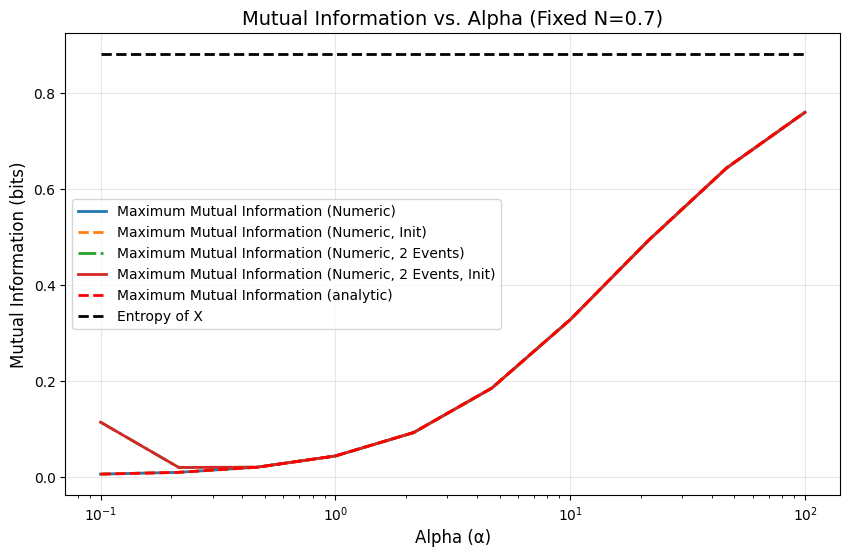

In [4]:
# Plot results
plt.figure(figsize=(10, 6))

plt.plot(A_values, mutual_infos_num, '-', linewidth=2, label="Maximum Mutual Information (Numeric)")
plt.plot(A_values, mutual_infos_num_with_init, '--', linewidth=2, label="Maximum Mutual Information (Numeric, Init)")

plt.plot(A_values, mutual_infos_num_2step, '-.', linewidth=2, label="Maximum Mutual Information (Numeric, 2 Events)")
plt.plot(A_values, mutual_infos_num_2step_with_init, '-', linewidth=2, label="Maximum Mutual Information (Numeric, 2 Events, Init)")

plt.plot(A_values, mutual_infos_analytic, 'r--', linewidth=2, label="Maximum Mutual Information (analytic)")

plt.plot(A_values, np.ones_like(A_values)*x_ent, 'k--', linewidth=2 , label = "Entropy of X")
plt.xlabel('Alpha (α)', fontsize=12)
plt.ylabel('Mutual Information (bits)', fontsize=12)
plt.title(f'Mutual Information vs. Alpha (Fixed N={N})', fontsize=14)
plt.xscale('log') 
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()

Note that the mutual information with two detection events and initial conditions seems to behave poorly numerically at low alpha.

# Vectorized Computations

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from binary_markov_funcs import (rates_from_params,
                                mutual_information_calc,
                                two_state_system_dt, 
                                two_state_system_detection_dt,
                                steady_state_sim,
                                steady_state_when_event_occurs,
                                survival_probabilities_given_initial_state,
                                compute_prob_time_since_last_event,
                                death_event_probs,
                                prob_x_given_detection_t_and_init,
                                numerical_mutual_info_onestep_vectorized,
                                numerical_mutual_info_onestep_vectorized_with_init,
                                fast_numerical_mutual_info_twostep,
                                fast_numerical_mutual_info_twostep_with_init)

# Define rates
N = 0.7  # Fixed occupation number
A_values = np.logspace(-1, 2, 20)  # Range of alpha values to test

# Time parameters
t_max = 50.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Simulation parameters
initial_p = np.array([1.0, 0.0])  # Start in OFF state
num_states = len(initial_p)

# Storage for results
mutual_infos_fast_num = []
mutual_infos_fast_num_with_init = []
mutual_infos_fast_num_2step = []
mutual_infos_fast_num_2step_with_init = []

mutual_infos_analytic = []

# Calculate mutual information for each alpha
for A in A_values:
    # Convert parameters to rates
    k_on, k_off, alpha = rates_from_params(N, A)

    mi, joint_ent, t_ent, x_ent = mutual_information_calc(k_on, k_off, alpha, t_eval, dt)
    mutual_infos_analytic.append(mi)
    
    # Obtain PDFs
    steady_state = steady_state_sim(two_state_system_dt, initial_p, t_max, dt, k_on, k_off)
    initial_state = steady_state_when_event_occurs(steady_state)
    
    # Time dependent evolution
    solution = survival_probabilities_given_initial_state(two_state_system_detection_dt, num_states, t_max, dt,
                                                  k_off, k_on, alpha)
    # A couple derived PDFs from the time evolution
    prob_time_since_last_event = compute_prob_time_since_last_event(solution, dt)
    death_probs = death_event_probs(solution, dt)
    prob_x_given_t_and_init = prob_x_given_detection_t_and_init(solution)
    
    # Fast vectorized calculations
    fast_joint_entropy, fast_time_entropy = numerical_mutual_info_onestep_vectorized(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric = fast_time_entropy + x_ent - fast_joint_entropy
    mutual_infos_fast_num.append(fast_mi_numeric)
    
    fast_joint_entropy_init, fast_time_entropy_init = numerical_mutual_info_onestep_vectorized_with_init(t_eval, dt, initial_state, prob_time_since_last_event)
    fast_mi_numeric_init = fast_time_entropy_init + x_ent - fast_joint_entropy_init
    mutual_infos_fast_num_with_init.append(fast_mi_numeric_init)

    fast_joint_entropy_2step, fast_time_entropy_2step = fast_numerical_mutual_info_twostep(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=5000)
    fast_mi_numeric_2step = fast_time_entropy_2step + x_ent - fast_joint_entropy_2step
    mutual_infos_fast_num_2step.append(fast_mi_numeric_2step)

    fast_joint_entropy_2step_init, fast_time_entropy_2step_init = fast_numerical_mutual_info_twostep_with_init(t_eval, dt, initial_state, prob_time_since_last_event, death_probs, prob_x_given_t_and_init, chunk_size=5000)
    fast_mi_numeric_2step_init = fast_time_entropy_2step_init + x_ent - fast_joint_entropy_2step_init
    mutual_infos_fast_num_2step_with_init.append(fast_mi_numeric_2step_init)

print("Done calculations!")


Done calculations!


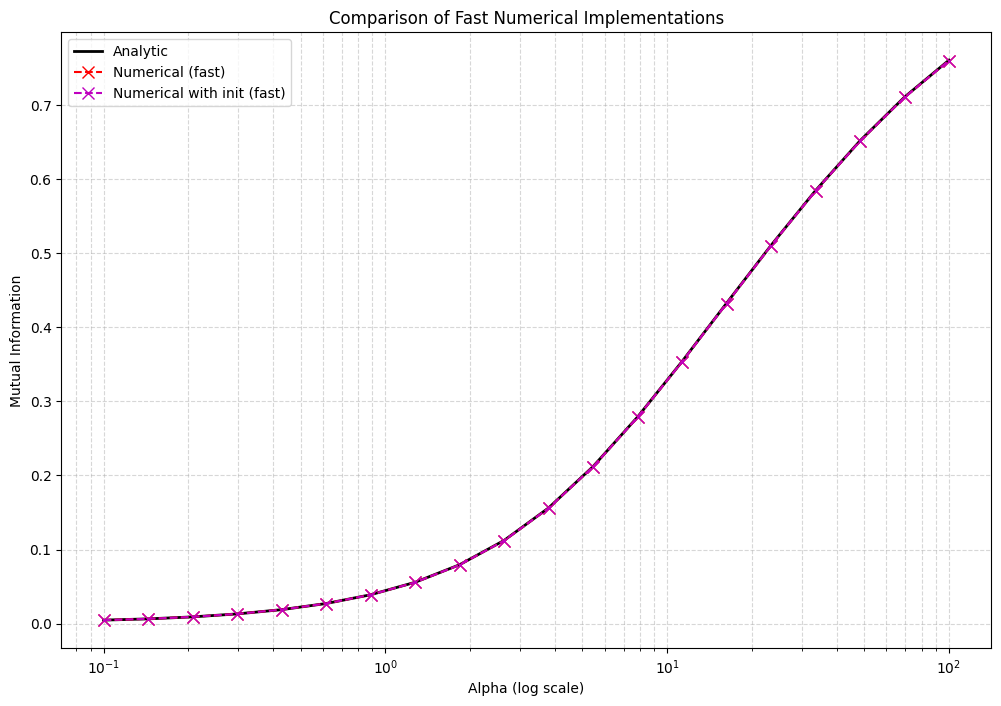

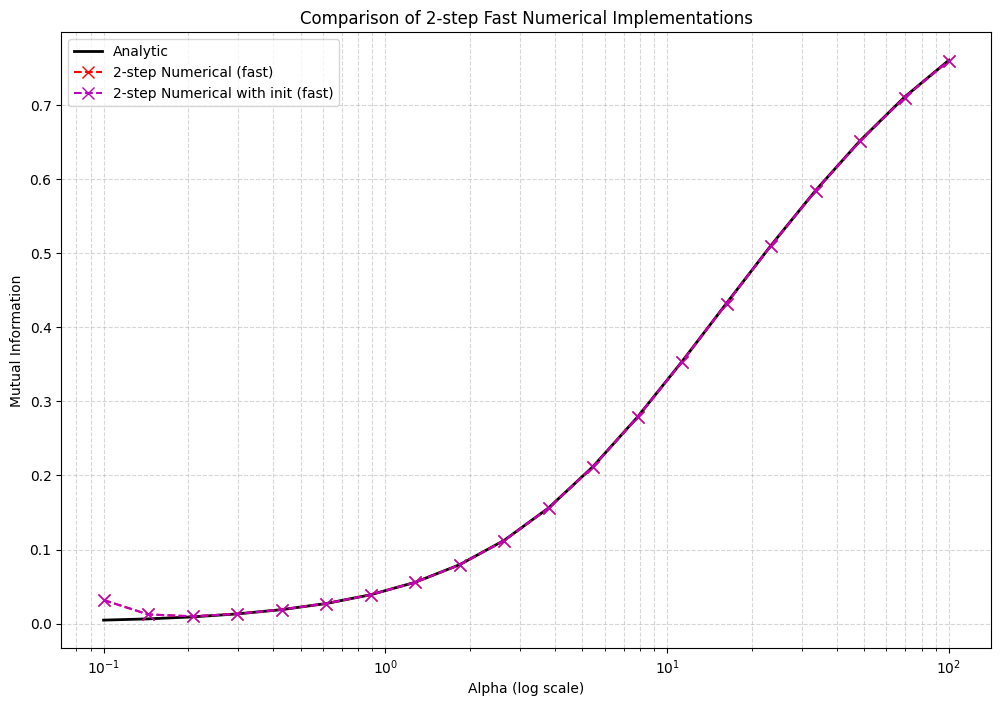

In [7]:
# Plot comparison between original and fast versions
plt.figure(figsize=(12, 8))
plt.semilogx(A_values, mutual_infos_analytic, 'k-', label='Analytic', linewidth=2)
plt.semilogx(A_values, mutual_infos_fast_num, 'rx--', label='Numerical (fast)', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_with_init, 'mx--', label='Numerical with init (fast)', markersize=8)
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mutual Information')
plt.title('Comparison of Fast Numerical Implementations')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

# Plot two-step comparison
plt.figure(figsize=(12, 8))
plt.semilogx(A_values, mutual_infos_analytic, 'k-', label='Analytic', linewidth=2)
plt.semilogx(A_values, mutual_infos_fast_num_2step, 'rx--', label='2-step Numerical (fast)', markersize=8)
plt.semilogx(A_values, mutual_infos_fast_num_2step_with_init, 'mx--', label='2-step Numerical with init (fast)', markersize=8)
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mutual Information')
plt.title('Comparison of 2-step Fast Numerical Implementations')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()